In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import wfdb

In [302]:
ecg_path = '/home/xu0005/Desktop/ECG_data/ptb-xl/1.0.3/records500/00000/00020_hr'

## Read ECG Raw Data

In [303]:
ecg_data = wfdb.rdsamp(ecg_path)
ecg_sig, ecg_meta = ecg_data[0], ecg_data[1]
ecg_sig.shape, ecg_meta.keys()

((5000, 12),
 dict_keys(['fs', 'sig_len', 'n_sig', 'base_date', 'base_time', 'units', 'sig_name', 'comments']))

## Preprocessing

### Check the power-line noise

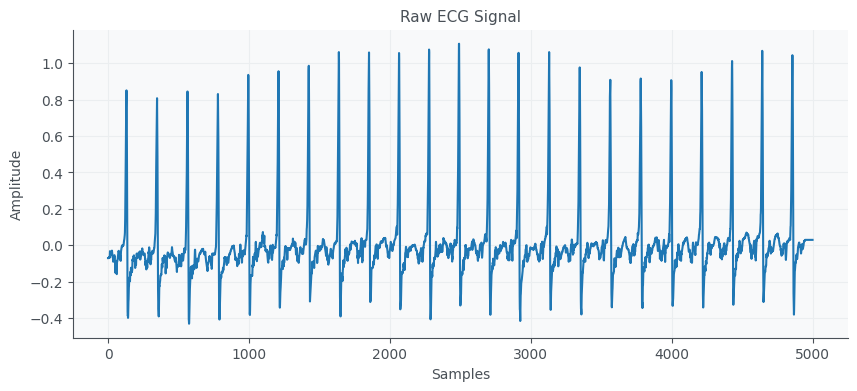

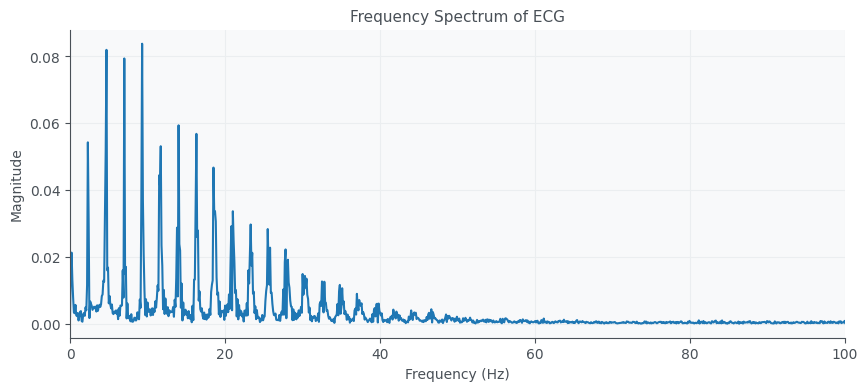

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Assuming `ecg_sig` is your raw ECG data for one lead
ecg_lead = ecg_sig[:, 0]  # Analyzing the first lead

# Plot the time-domain signal
plt.figure(figsize=(10, 4))
plt.plot(ecg_lead)
plt.title('Raw ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

# Perform a Fourier Transform to analyze frequency components
fs = 500
n = len(ecg_lead)
frequencies = np.linspace(0.0, fs/2, n//2)
ecg_fft = fft(ecg_lead)
ecg_fft_mag = 2.0/n * np.abs(ecg_fft[:n//2])

# Plot the frequency spectrum
plt.figure(figsize=(10, 4))
plt.plot(frequencies, ecg_fft_mag)
plt.title('Frequency Spectrum of ECG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 100)  # Limiting to 100 Hz to focus on the lower frequencies
plt.show()


### It seems there is no clear power-line noise, so we will not perform the notch filer below

In [305]:
from scipy.signal import butter, lfilter, filtfilt, iirnotch

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, freq, fs, Q=30):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = iirnotch(freq, Q)
    y = filtfilt(b, a, data)
    return y

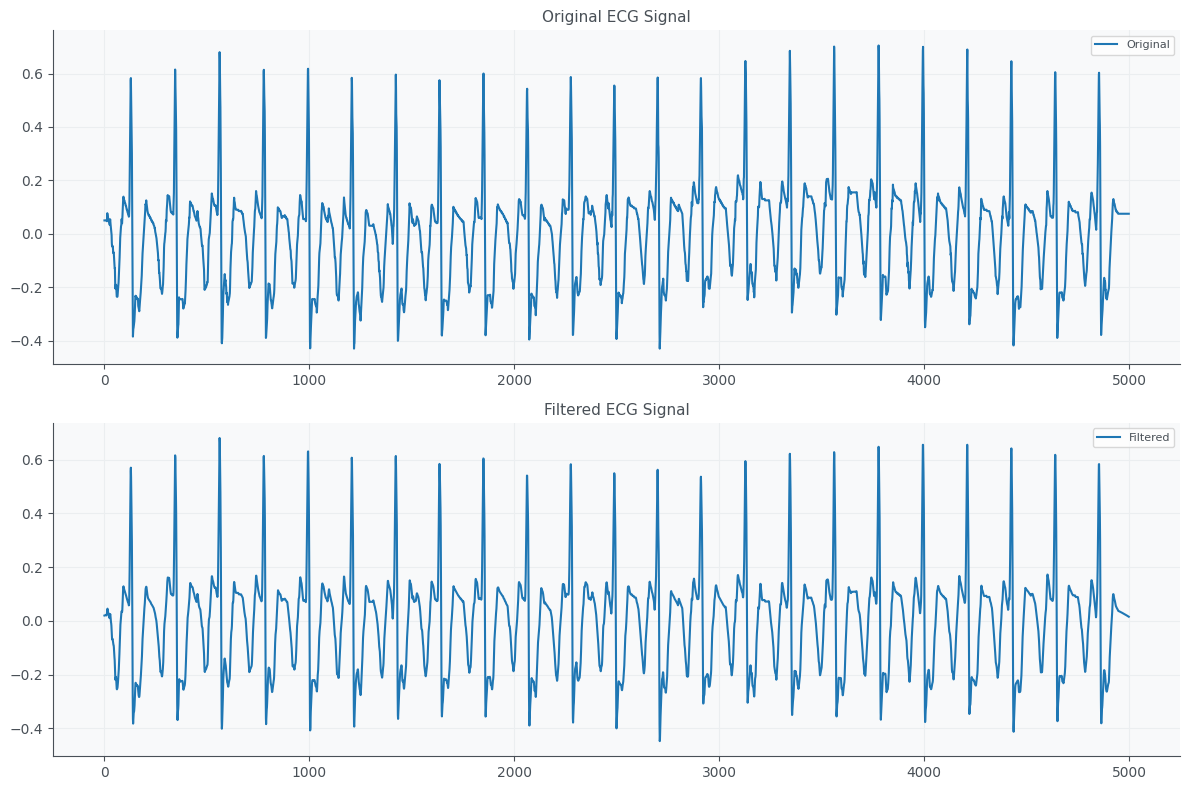

In [306]:
ecg_ch = 1

# Sampling rate
fs = 500

# Apply bandpass filter
lowcut = 0.5
highcut = 100  # High frequency of the bandpass filter
ecg_filtered = butter_bandpass_filter(ecg_sig[:, ecg_ch], lowcut, highcut, fs, order=5)

## Apply notch filter at 50 Hz (adjust this if you are in a region with 60 Hz)
# freq = 50  # Adjust this based on local power line frequency
# ecg_filtered = notch_filter(ecg_filtered, freq, fs)

# Plot original and filtered signals
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(ecg_sig[:, ecg_ch], label='Original')
plt.title('Original ECG Signal')
plt.legend()
plt.subplot(212)
plt.plot(ecg_filtered, label='Filtered')
plt.title('Filtered ECG Signal')
plt.legend()
plt.tight_layout()
plt.show()

In [307]:
# 初始化一个新的数组，用于存储所有处理后的信号
filtered_ecg_signals = np.zeros_like(ecg_sig)

# 对每个通道进行处理
for i in range(ecg_sig.shape[1]):  # 假设ecg_sig的第二维是通道维
    # 应用带通滤波器
    temp_filtered = butter_bandpass_filter(ecg_sig[:, i], lowcut, highcut, fs, order=4)
    filtered_ecg_signals[:, i] = temp_filtered

filtered_ecg_signals.shape

(5000, 12)

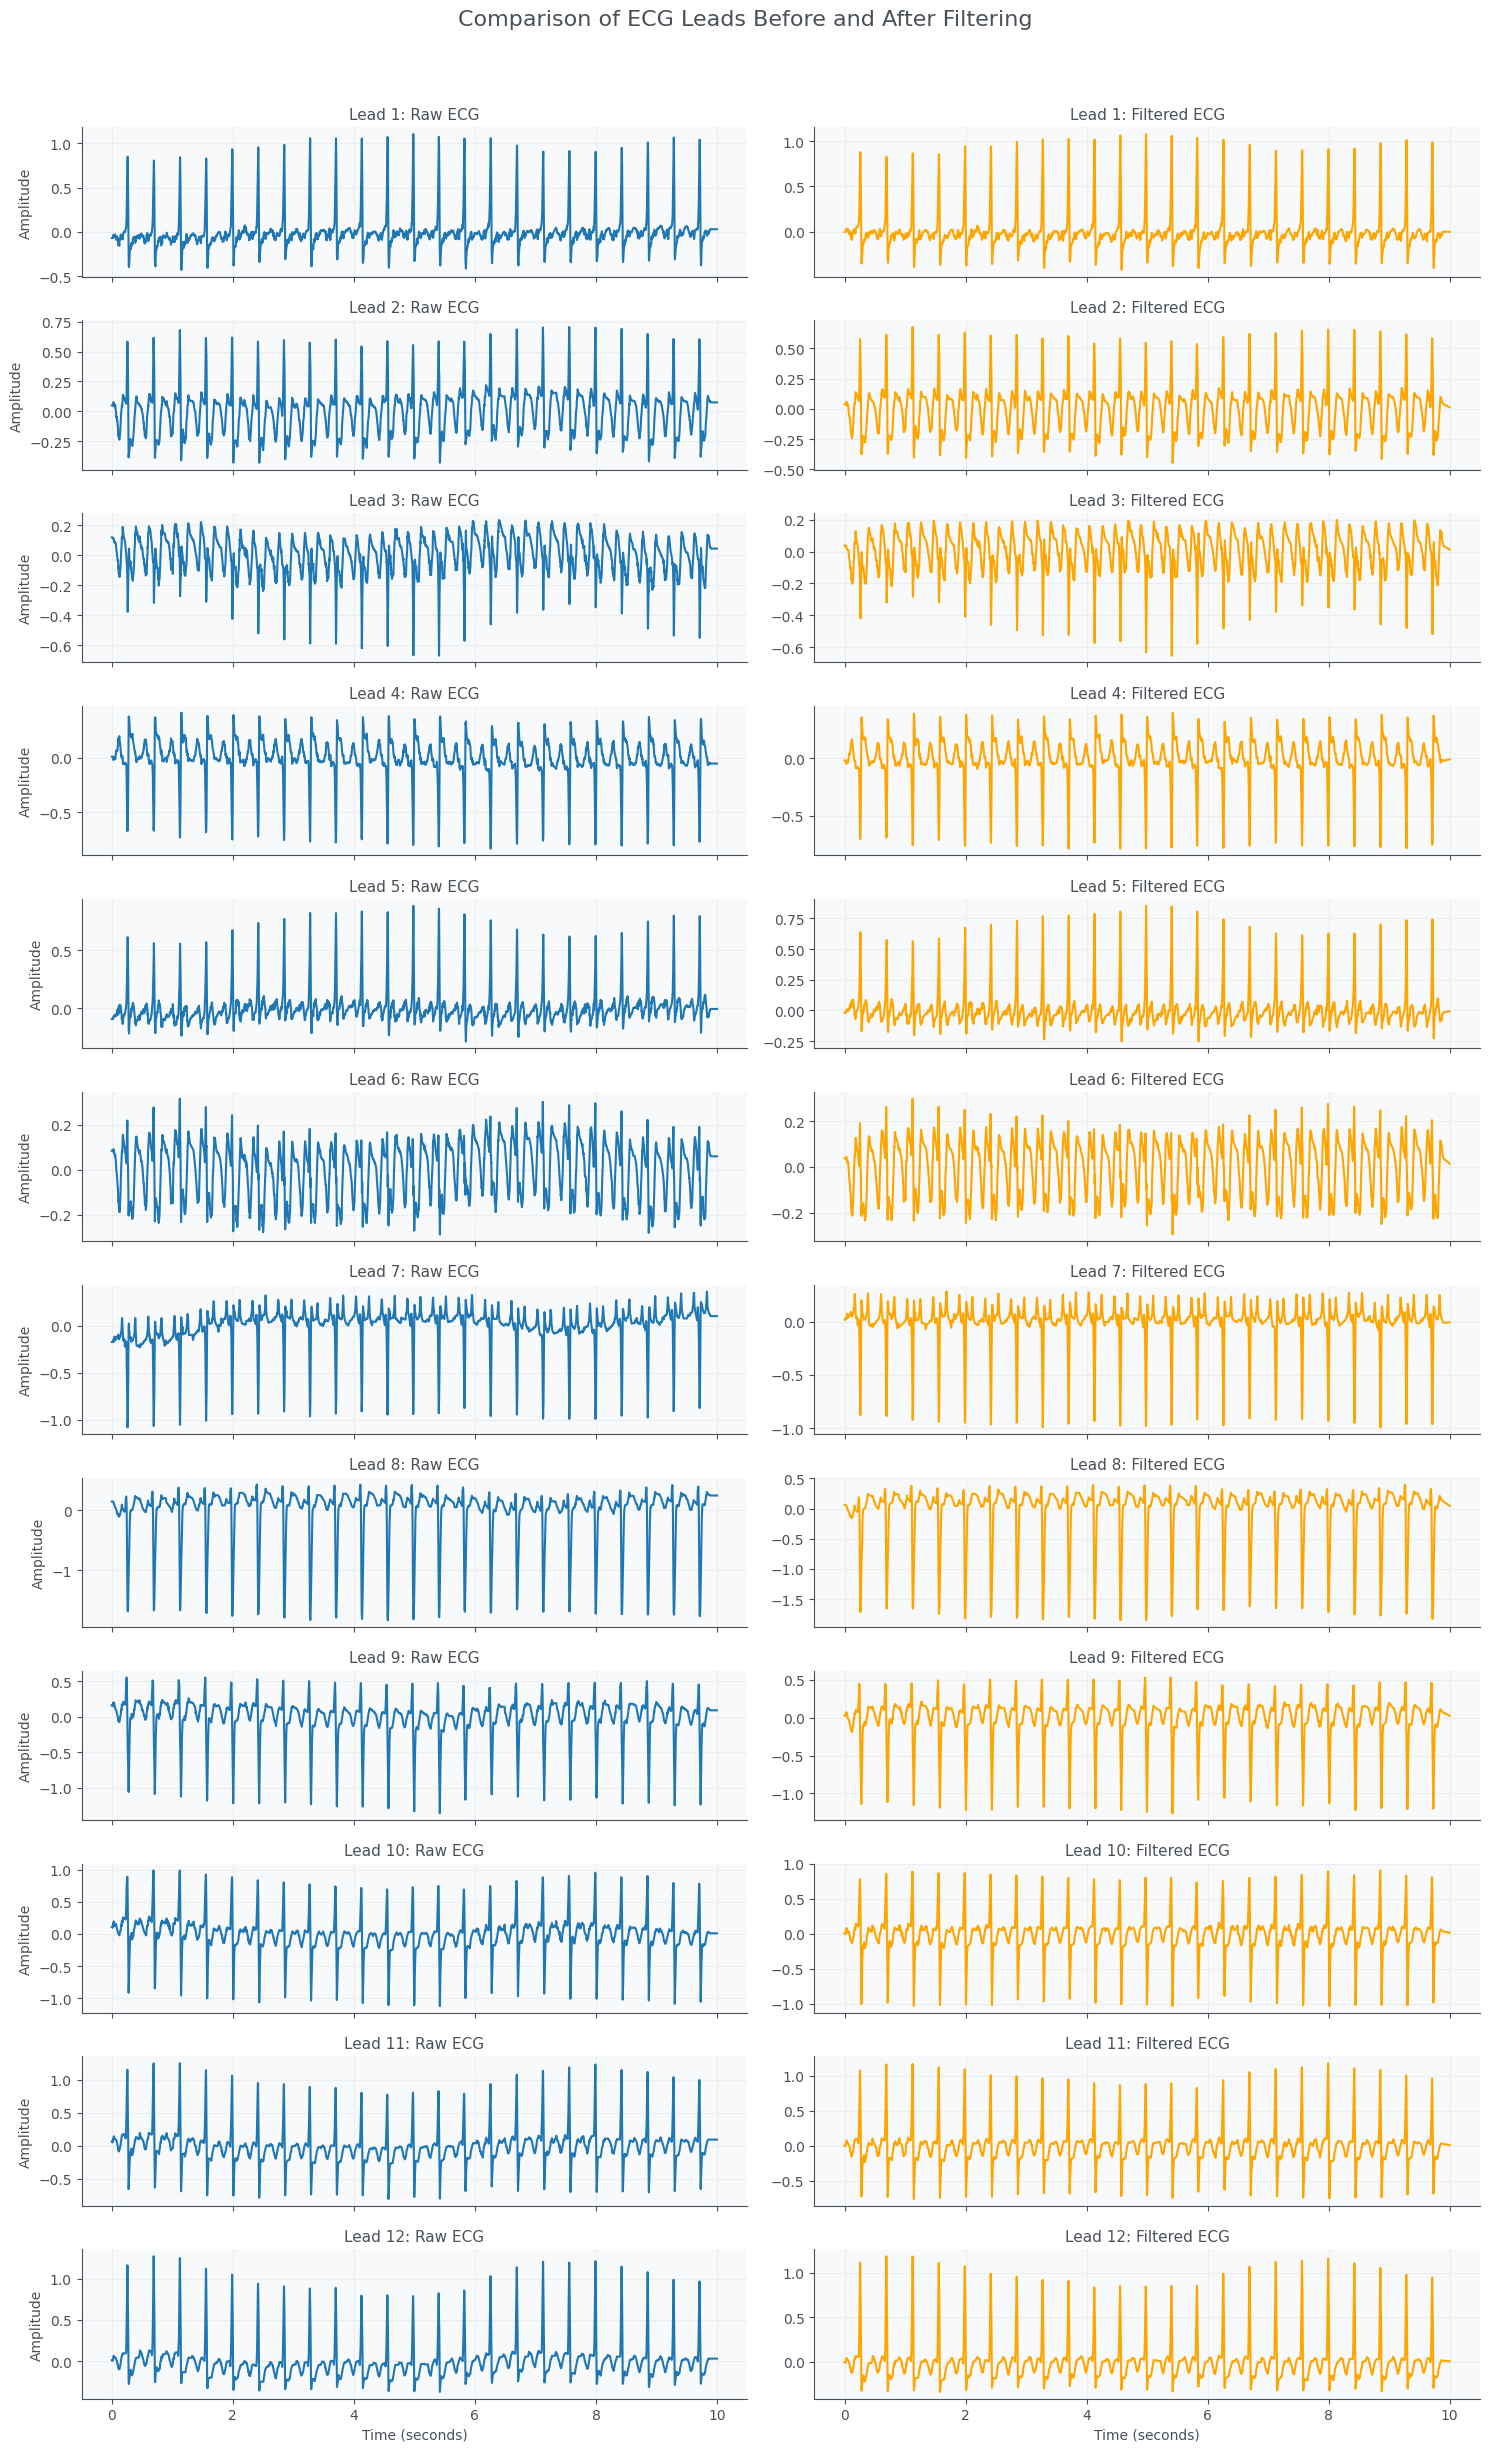

In [308]:
import matplotlib.pyplot as plt

def plot_ecg_leads(raw_ecg, filtered_ecg, leads, fs):
    """
    Plots each ECG lead before and after filtering.

    Parameters:
        raw_ecg (np.array): The raw ECG data array.
        filtered_ecg (np.array): The filtered ECG data array.
        leads (int): Number of leads/channels in the ECG data.
        fs (int): Sampling frequency in Hz.
    """
    time = np.linspace(0, raw_ecg.shape[0] / fs, raw_ecg.shape[0])

    fig, axes = plt.subplots(nrows=leads, ncols=2, figsize=(15, 2 * leads), sharex=True)
    fig.suptitle('Comparison of ECG Leads Before and After Filtering', fontsize=16, y=1.02)

    for i in range(leads):
        # Raw ECG
        ax = axes[i, 0]
        ax.plot(time, raw_ecg[:, i], label='Raw ECG Lead {}'.format(i+1))
        ax.set_title('Lead {}: Raw ECG'.format(i+1))
        ax.set_ylabel('Amplitude')
        if i == leads - 1:
            ax.set_xlabel('Time (seconds)')

        # Filtered ECG
        ax = axes[i, 1]
        ax.plot(time, filtered_ecg[:, i], label='Filtered ECG Lead {}'.format(i+1), color='orange')
        ax.set_title('Lead {}: Filtered ECG'.format(i+1))
        if i == leads - 1:
            ax.set_xlabel('Time (seconds)')

    plt.tight_layout()
    plt.show()

# Assuming ecg_sig is your raw ECG data and filtered_ecg_signals is the filtered data
plot_ecg_leads(ecg_sig, filtered_ecg_signals, 12, fs)


## Extract Meaningful Feature

### Extracting Heart Rate and RR Intervals

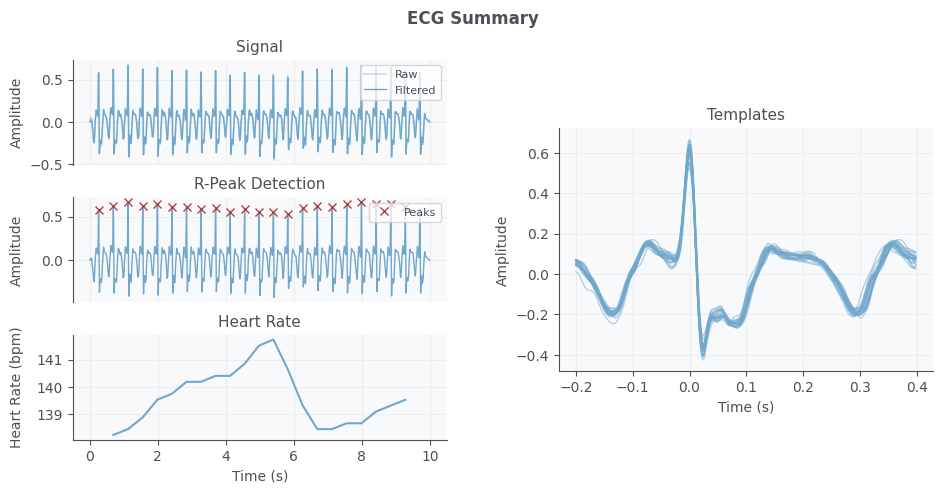

RR intervals: [434. 434. 432. 430. 428. 430. 426. 428. 428. 426. 424. 422. 424. 434.
 434. 432. 434. 432. 432. 430. 430.]
Heart rate: [138.24884793 138.24884793 138.88888889 139.53488372 140.18691589
 139.53488372 140.84507042 140.18691589 140.18691589 140.84507042
 141.50943396 142.18009479 141.50943396 138.24884793 138.24884793
 138.88888889 138.24884793 138.88888889 138.88888889 139.53488372
 139.53488372]


In [309]:
from biosppy.signals import ecg

sampling_rate = 500  # in Hz
# Select a single lead; usually, lead II is used
lead_ii = filtered_ecg_signals[:, 1]  # Assuming the second column is Lead II

# Extract ECG features
out = ecg.ecg(signal=lead_ii, sampling_rate=sampling_rate, show=True)

# RR intervals
rr_intervals = np.diff(out['rpeaks']) / sampling_rate * 1000  # Convert to ms

# Heart rate calculation
heart_rate = 60 / (rr_intervals / 1000)  # in beats per minute

print('RR intervals:', rr_intervals)
print('Heart rate:', heart_rate)

In [310]:
import numpy as np
from biosppy.signals import ecg

# Assuming your ECG data is stored in an array called `ecg_data` and using only the first lead
# Normally, you would process possibly all leads or select leads depending on your clinical focus
lead_index = 1  # change this based on which lead you want to analyze (usually lead II is used)
single_lead_ecg = filtered_ecg_signals[:, lead_index]

# Analyze the ECG signal to find the R-peaks, and other waves
out = ecg.ecg(signal=single_lead_ecg, sampling_rate=500, show=False)

# Extract RR intervals
rr_intervals = np.diff(out['rpeaks']) / 500.0 * 1000  # convert to milliseconds

# Calculate heart rate
heart_rate = 60 / (rr_intervals / 1000)  # in beats per minute

# For QT interval, you need to detect the onset of the Q wave and the offset of the T wave
# This is more complex and may require additional processing or different library functions
# which are not directly provided by biosppy. You may need to define or adjust detection algorithms

print("RR Intervals (ms):", rr_intervals)
print("Heart Rate (bpm):", heart_rate)
print(rr_intervals.mean(), heart_rate.mean())
# print("QT Intervals (ms):", qt_intervals)  # You would add this line once QT intervals are calculated


RR Intervals (ms): [434. 434. 432. 430. 428. 430. 426. 428. 428. 426. 424. 422. 424. 434.
 434. 432. 434. 432. 432. 430. 430.]
Heart Rate (bpm): [138.24884793 138.24884793 138.88888889 139.53488372 140.18691589
 139.53488372 140.84507042 140.18691589 140.18691589 140.84507042
 141.50943396 142.18009479 141.50943396 138.24884793 138.24884793
 138.88888889 138.24884793 138.88888889 138.88888889 139.53488372
 139.53488372]
429.7142857142857 139.63758006145204


### Extract R-Peaks and delineate the QRS complex

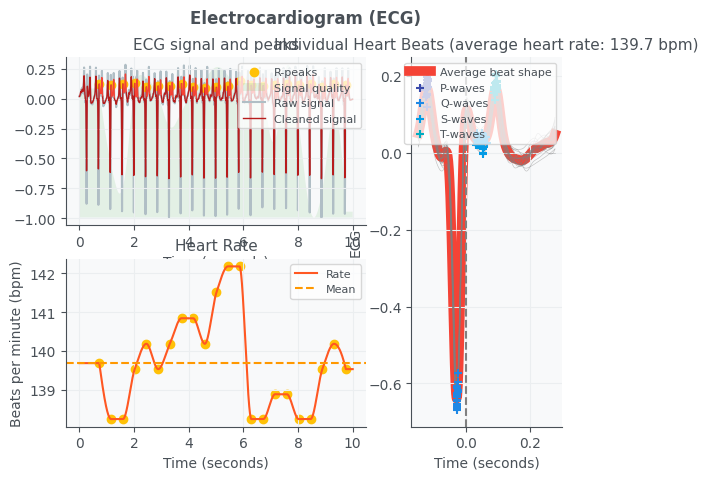

In [319]:
import neurokit2 as nk

signals, info = nk.ecg_process(filtered_ecg_signals[:, 6], sampling_rate=500)
nk.ecg_plot(signals, info)

# turn signal into dataframe
signals_df = pd.DataFrame(signals)
signals_df.head()

# save the signal to a csv file
signals_df.to_csv('00005_hr_ecg_signals.csv', index=False)

In [312]:
sampling_rate = 500
lead_II = filtered_ecg_signals[:, 1]
ecg_signals, info = nk.ecg_process(lead_II, sampling_rate=sampling_rate)
waves, waves_info = nk.ecg_delineate(ecg_signals["ECG_Clean"], info, sampling_rate=sampling_rate, method="dwt")

for key in waves_info:
    print(key, ":\n", waves_info[key])

ECG_P_Peaks :
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
ECG_P_Onsets :
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
ECG_P_Offsets :
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
ECG_Q_Peaks :
 [330, 547, 763, 977, 1192, 1407, 1620, 1833, 2047, 2209, 2473, 2684, 2895, 3113, 3329, 3546, 3763, 3980, 4196, 4410, 4624, nan]
ECG_R_Onsets :
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
ECG_R_Offsets :
 [368, nan, nan, 1016, 1231, 1445, nan, nan, 2086, 2299, nan, nan, 2936, 3152, 3369, nan, nan, nan, nan, nan, nan, 4878]
ECG_S_Peaks :
 [362, 578, 795, 1010, 1224, 1439, 1653, 1867, 2080, 2292, 2505, 2716, 2929, 3145, 3362, 3579, 3795, 4011, 4228, 4442, 4657, nan]
ECG_T_Peaks :
 [424, nan, nan, 1067, 1281, 1494, nan, nan, 2136, 235

In [258]:
# 计算QT间期（以样本数表示）
t_offsets = np.array(waves_info["ECG_T_Offsets"])
r_onsets = np.array(waves_info["ECG_R_Onsets"])
qt_samples = t_offsets - r_onsets

# 转换为毫秒（假设采样率为500Hz）
qt_intervals_ms = qt_samples * 1000 / 500

# 计算统计特征
qt_mean = np.nanmean(qt_intervals_ms)
qt_std = np.nanstd(qt_intervals_ms)
qt_min = np.nanmin(qt_intervals_ms)
qt_max = np.nanmax(qt_intervals_ms)
qt_median = np.nanmedian(qt_intervals_ms)
qt_iqr = np.percentile(qt_intervals_ms, 75) - np.percentile(qt_intervals_ms, 25)

qt_stats = {
    'mean': qt_mean,
    'std': qt_std,
    'min': qt_min,
    'max': qt_max,
    'median': qt_median,
    'iqr': qt_iqr
}

# 打印统计结果
print("QT Interval Statistics:")
for stat, value in qt_stats.items():
    print(f"{stat}: {value:.2f} ms")


QT Interval Statistics:
mean: 425.33 ms
std: 32.46 ms
min: 382.00 ms
max: 458.00 ms
median: 450.00 ms
iqr: nan ms


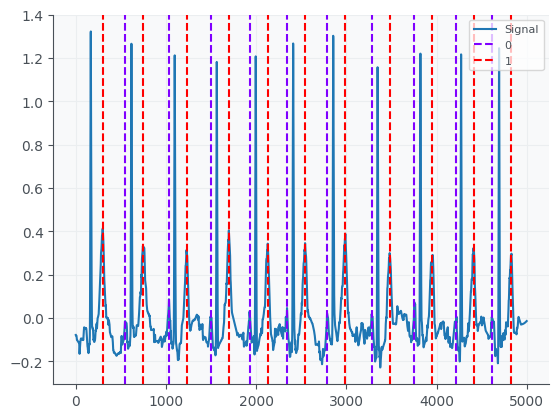

In [234]:
_, rpeaks = nk.ecg_peaks(filtered_ecg_signals[:, 1], sampling_rate=500)
signals, waves = nk.ecg_delineate(filtered_ecg_signals[:, 1], rpeaks, sampling_rate=500)

nk.events_plot([waves["ECG_P_Peaks"], waves["ECG_T_Peaks"]], filtered_ecg_signals[:, 1])

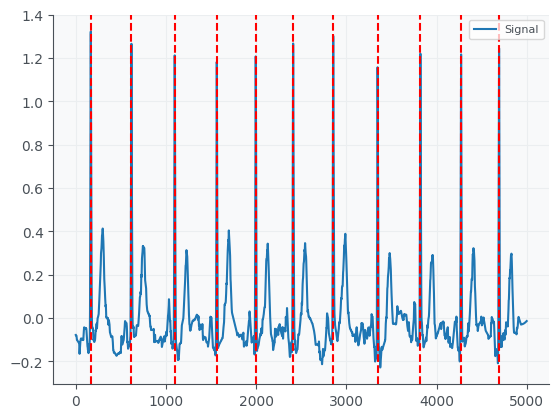

In [218]:

single_lead_ecg = filtered_ecg_signals[:, 1]  # Assuming the second column is Lead II
_, rpeaks = nk.ecg_peaks(single_lead_ecg, sampling_rate=500)

plot = nk.events_plot(rpeaks['ECG_R_Peaks'], single_lead_ecg)

In [ ]:
nk.ecg_process()

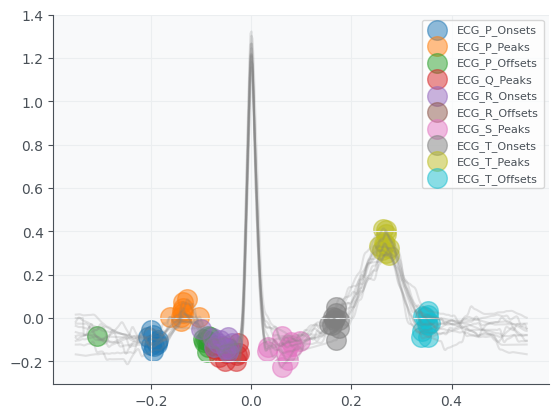

In [235]:
import neurokit2 as nk

# Delineate the ECG signal
signal_cwt, waves_cwt = nk.ecg_delineate(single_lead_ecg, 
                                         rpeaks, 
                                         sampling_rate=500, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='all')

In [236]:
waves_cwt

{'ECG_P_Onsets': [523, 999, 1469, 1895, 2310, 2756, 3142, 3728, 4175, 4590],
 'ECG_P_Peaks': [547, 1033, 1493, 1926, 2342, 2786, 3167, 3753, 4220, 4612],
 'ECG_P_Offsets': [574, 1056, 1520, 1947, 2363, 2811, 3192, 3776, 4233, 4649],
 'ECG_Q_Peaks': [142,
  581,
  1074,
  1549,
  1983,
  2378,
  2841,
  3320,
  3792,
  4257,
  nan],
 'ECG_R_Onsets': [117,
  nan,
  1064,
  1541,
  1972,
  2391,
  2823,
  3309,
  3783,
  4247,
  4670],
 'ECG_R_Offsets': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'ECG_S_Peaks': [206,
  647,
  1133,
  1579,
  2010,
  2444,
  2902,
  3376,
  3857,
  4313,
  nan],
 'ECG_T_Onsets': [248, 694, 1177, 1647, 2078, 2492, 2938, 3430, 3908, 4359],
 'ECG_T_Peaks': [298, 744, 1227, 1697, 2128, 2542, 2988, 3480, 3958, 4409],
 'ECG_T_Offsets': [340, 793, 1267, 1739, 2171, 2581, 3032, 3521, 3990, 4448]}

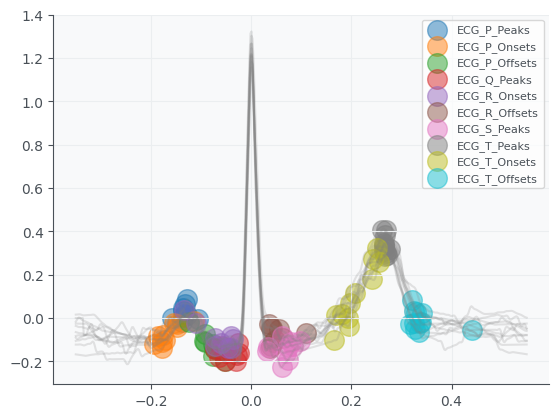

In [216]:
# Delineate the ECG signal
signal_dwt, waves_dwt = nk.ecg_delineate(single_lead_ecg, 
                                         rpeaks, 
                                         sampling_rate=500, 
                                         method="dwt", 
                                         show=True, 
                                         show_type='all')

In [217]:
waves_cwt

{'ECG_P_Onsets': [523, 999, 1469, 1895, 2310, 2756, 3142, 3728, 4175, 4590],
 'ECG_P_Peaks': [547, 1033, 1493, 1926, 2342, 2786, 3167, 3753, 4220, 4612],
 'ECG_P_Offsets': [574, 1056, 1520, 1947, 2363, 2811, 3192, 3776, 4233, 4649],
 'ECG_Q_Peaks': [142,
  581,
  1074,
  1549,
  1983,
  2378,
  2841,
  3320,
  3792,
  4257,
  nan],
 'ECG_R_Onsets': [117,
  nan,
  1064,
  1541,
  1972,
  2391,
  2823,
  3309,
  3783,
  4247,
  4670],
 'ECG_R_Offsets': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'ECG_S_Peaks': [206,
  647,
  1133,
  1579,
  2010,
  2444,
  2902,
  3376,
  3857,
  4313,
  nan],
 'ECG_T_Onsets': [248, 694, 1177, 1647, 2078, 2492, 2938, 3430, 3908, 4359],
 'ECG_T_Peaks': [298, 744, 1227, 1697, 2128, 2542, 2988, 3480, 3958, 4409],
 'ECG_T_Offsets': [340, 793, 1267, 1739, 2171, 2581, 3032, 3521, 3990, 4448]}

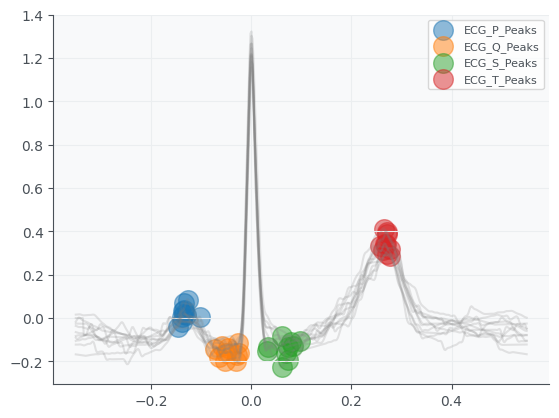

In [223]:
_, waves_peak = nk.ecg_delineate(single_lead_ecg, 
                                 rpeaks, 
                                 sampling_rate=500, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')

In [294]:
def comppute_rpeaks(single_lead_ecg):
    _, rpeaks = nk.ecg_peaks(single_lead_ecg, sampling_rate=500)
    return rpeaks

def compute_rr_feats(rpeaks, lead, fs=500):
    rr_feats = {}

    rr_intervals = np.diff(rpeaks['ECG_R_Peaks'])  / fs * 1000  # Convert to ms
    heart_rate = 60 / (rr_intervals / 1000)             # in beats per minute
    
    mean_rr = np.mean(rr_intervals)                     # 所有RR间隔的平均值。
    sdnn = np.std(rr_intervals)                         # RR间隔的标准差，用于衡量心率变异性。
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))  # RR间隔的均方根差，用于衡量心率变异性。
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)   # RR间隔差异大于50ms的次数。
    pnn50 = nn50 / len(rr_intervals)                    # RR间隔差异大于50ms的比例。

    rr_feats['mean_rr'] = mean_rr
    rr_feats['sdnn'] = sdnn
    rr_feats['rmssd'] = rmssd
    rr_feats['nn50'] = nn50
    rr_feats['pnn50'] = pnn50
    rr_feats['hr_mean'] = np.mean(heart_rate)  

    return rr_feats


def compute_pqr_feats(waves_info, lead, fs=500):
    pqr_feats = {}

    # 计算P波时长，并转换为毫秒
    p_duration_samples = np.array(waves_info["ECG_P_Offsets"]) - np.array(waves_info["ECG_P_Onsets"])
    p_duration_ms = p_duration_samples * 1000 / fs  # 转换为毫秒
    pqr_feats['p_duration'] = np.nanmean(p_duration_ms)

    # 计算QRS复合波时长，并转换为毫秒
    qrs_duration_samples = np.array(waves_info["ECG_R_Offsets"]) - np.array(waves_info["ECG_R_Onsets"])
    qrs_duration_ms = qrs_duration_samples * 1000 / fs  # 转换为毫秒
    pqr_feats['qrs_duration'] = np.nanmean(qrs_duration_ms)

    # 计算T波时长，并转换为毫秒
    t_duration_samples = np.array(waves_info["ECG_T_Offsets"]) - np.array(waves_info["ECG_T_Onsets"])
    t_duration_ms = t_duration_samples * 1000 / fs  # 转换为毫秒
    pqr_feats['t_duration'] = np.nanmean(t_duration_ms)

    # 计算QT间期，并转换为毫秒
    qt_interval_samples = np.array(waves_info["ECG_T_Offsets"]) - np.array(waves_info["ECG_R_Onsets"])
    qt_interval_ms = qt_interval_samples * 1000 / fs  # 转换为毫秒
    pqr_feats['qt_interval'] = np.nanmean(qt_interval_ms)

    return pqr_feats


def compute_amplitude_feats(ecg_sig, rpeaks, waves_info, lead):
    p_peaks = np.array(waves_info["ECG_P_Peaks"])
    t_peaks = np.array(waves_info["ECG_T_Peaks"])
    qrs_peaks = np.array(rpeaks)

    # 删除NaN值
    p_peaks = p_peaks[~np.isnan(p_peaks)].astype(int)
    t_peaks = t_peaks[~np.isnan(t_peaks)].astype(int)
    qrs_peaks = qrs_peaks[~np.isnan(qrs_peaks)].astype(int)
    
    p_amplitudes = ecg_sig[p_peaks]
    qrs_amplitudes = ecg_sig[qrs_peaks]
    t_amplitudes = ecg_sig[t_peaks]

    amplitude_feats = {
        'p_amp_mean': np.mean(p_amplitudes),
        'p_amp_std': np.std(p_amplitudes),
        'qrs_amp_mean': np.mean(qrs_amplitudes),
        'qrs_amp_std': np.std(qrs_amplitudes),
        't_amp_mean': np.mean(t_amplitudes),
        't_amp_std': np.std(t_amplitudes)
    }

    return amplitude_feats

In [ ]:
import ast

path="/home/xu0005/Desktop/ECG_data/ptb-xl/1.0.3/"
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

sampling_rate = 500

cnt = 0
for f in tqdm(Y.filename_hr):
    # cnt += 1
    # if cnt > 5:
    #     break

    ecg_sig, ecg_meta = wfdb.rdsamp(path+f)
    
    filtered_ecg_signals = np.zeros_like(ecg_sig)
    # 对每个通道进行处理
    for i in range(ecg_sig.shape[1]):  # ecg_sig的第二维是通道维
        temp_filtered = butter_bandpass_filter(ecg_sig[:, i], lowcut, highcut, fs, order=4)
        filtered_ecg_signals[:, i] = temp_filtered
    

    all_feats = []
    all_lead_success = True
    for lead in range(12):
        channel_ecg = filtered_ecg_signals[:, lead]
        rpeaks = comppute_rpeaks(channel_ecg)
        rr_feats = compute_rr_feats(rpeaks, fs=500, lead=lead)
    
        try:
            ecg_signals, info = nk.ecg_process(filtered_ecg_signals[:, lead], sampling_rate=sampling_rate)
        except:
            print("Error processing ECG signal for lead", lead)
            all_lead_success = False
            break

        waves, waves_info = nk.ecg_delineate(ecg_signals["ECG_Clean"], info, sampling_rate=sampling_rate, method="dwt")
        pqr_feats = compute_pqr_feats(waves_info, fs=500, lead=lead)

        amplitude_feats = compute_amplitude_feats(filtered_ecg_signals[:, lead], rpeaks=rpeaks['ECG_R_Peaks'], waves_info=waves_info, lead=lead)

        lead_feat = {**rr_feats, **pqr_feats, **amplitude_feats}
        all_feats.append(lead_feat)

    if not all_lead_success:
        continue

    f_name = f.split('/')[-1][:-3]

    folder = path + 'ecg_feats/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    csv_file_path = folder + f_name + '_ecg_feats.csv'
    pd.DataFrame(all_feats).to_csv(csv_file_path, index=False)



In [299]:
path = "/home/xu0005/Desktop/ECG_data/ptb-xl/1.0.3/ecg_feats/00005_ecg_feats.csv"

df = pd.read_csv(path)
df

,mean_rr,sdnn,rmssd,nn50,pnn50,hr_mean,p_duration,qrs_duration,t_duration,qt_interval,p_amp_mean,p_amp_std,qrs_amp_mean,qrs_amp_std,t_amp_mean,t_amp_std
0,905.200000,48.893353,58.076578,5,0.500000,66.478286,54.600000,150.888889,141.272727,412.666667,0.004726,0.027568,0.450081,0.028323,0.150067,0.046505
1,905.200000,48.597942,57.546117,5,0.500000,66.475678,106.800000,190.000000,145.272727,425.333333,0.021952,0.033367,1.236465,0.047641,0.333914,0.038835
2,863.090909,141.007707,137.882559,6,0.545455,72.773335,106.600000,180.666667,125.454545,390.444444,0.009318,0.022498,0.854678,0.241898,0.171059,0.034611
3,905.800000,66.383432,97.193964,5,0.500000,66.607845,86.600000,160.333333,106.571429,368.000000,0.085507,0.019612,0.115842,0.036225,0.084863,0.030126
4,863.818182,138.704275,134.533267,6,0.545455,72.551602,66.363636,137.200000,78.800000,211.000000,0.039984,0.018820,0.132334,0.043042,0.027964,0.024786
5,905.200000,48.639079,57.669557,5,0.500000,66.476145,105.800000,173.000000,138.545455,406.666667,0.012952,0.024143,1.075230,0.054183,0.252337,0.037517
6,905.400000,48.826632,57.892621,5,0.500000,66.462684,72.200000,153.000000,184.285714,311.000000,0.075561,0.014121,0.183583,0.017949,0.036068,0.013571
7,905.400000,49.258908,58.137767,5,0.500000,66.466821,112.400000,168.888889,168.545455,466.888889,0.012912,0.027565,0.574022,0.043072,0.390795,0.037874
8,905.400000,49.112524,58.191256,5,0.500000,66.465011,127.800000,160.000000,150.727273,449.142857,-0.050595,0.007922,0.750453,0.026655,0.420983,0.023421
9,905.200000,48.209543,56.917094,5,0.500000,66.472913,106.600000,168.000000,143.818182,448.285714,-0.045705,0.027418,1.514948,0.060438,0.355836,0.024128


# PTB-XL Age and Gender Statistics

In [5]:
file_path = "/home/xu0005/Desktop/ECG_data/ptb-xl/1.0.3/ptbxl_database.csv"

In [6]:
file = pd.read_csv(file_path)
file.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [7]:
age_count = file['age'].value_counts().sort_index()
age_count

age
2.0        1
3.0        2
4.0        2
5.0        2
6.0        1
        ... 
86.0     178
87.0     230
88.0     149
89.0      98
300.0    293
Name: count, Length: 89, dtype: int64

<Axes: xlabel='age'>

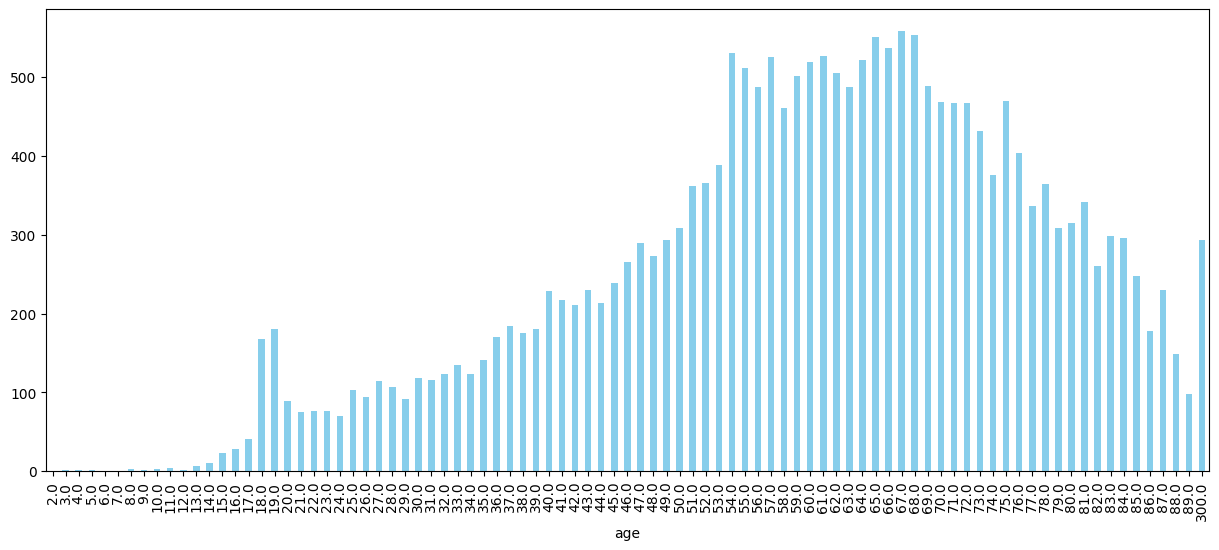

In [8]:
age_count.plot(kind='bar', figsize=(15, 6), color='skyblue')

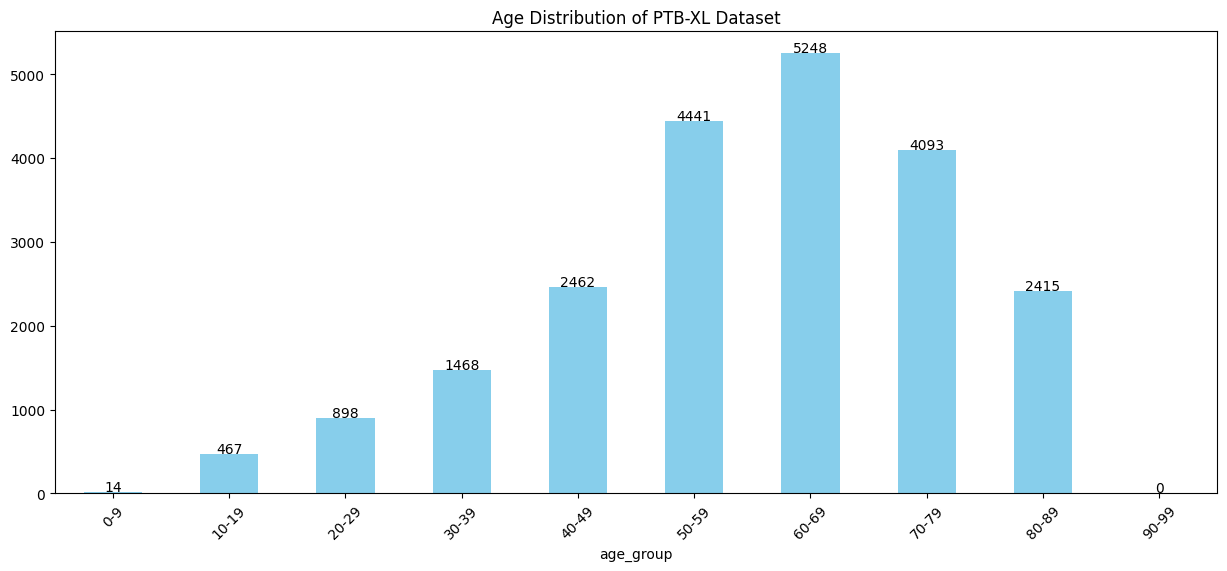

In [9]:
bins = range(0, 110, 10)
labels = [f'{i}-{i+9}' for i in bins[:-1]]

file['age_group'] = pd.cut(file['age'], bins=bins, labels=labels, right=False)
file['age_group'].value_counts().sort_index().plot(kind='bar', figsize=(15, 6), color='skyblue')
# rotate x-axis labels
plt.xticks(rotation=45)
# show numbers on top of bars
for i, v in enumerate(file['age_group'].value_counts().sort_index()):
    plt.text(i, v + 10, str(v), ha='center')
plt.title('Age Distribution of PTB-XL Dataset')
plt.show()

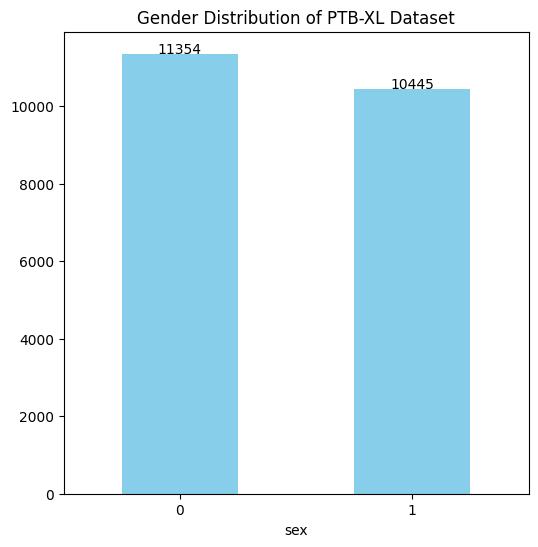

In [10]:
sex_count = file["sex"].value_counts()

# plot bar graph
sex_count.plot(kind='bar', figsize=(6, 6), color='skyblue')
plt.xticks(rotation=0)
# show numbers on top of bars
for i, v in enumerate(sex_count):
    plt.text(i, v + 10, str(v), ha='center')
plt.title("Gender Distribution of PTB-XL Dataset")
plt.show()

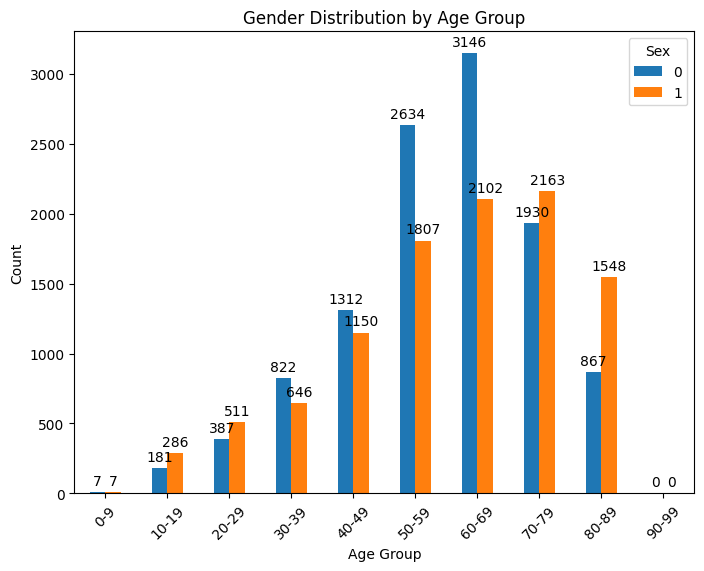

In [22]:
# Group by 'age_group' and 'sex' and count occurrences
gender_distribution = file.groupby(['age_group', 'sex'], observed=False).size().unstack(fill_value=0)

# Plotting
gender_distribution.plot(kind='bar', figsize=(8, 6), stacked=False)
# Add numbers on top of the bars
ax = plt.gca()  # Get current axis
for p in ax.patches:  # Loop over every bar
    ax.annotate(str(p.get_height()),  # Get the height of the bar
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the label
                ha='center', va='center',  # Center alignment
                xytext=(0, 8),  # 10 points vertical offset
                textcoords='offset points')

plt.title('Gender Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sex', labels=['0', '1'])
plt.show()